In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import seaborn as sns
from scipy import stats
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
sns.set()

# yvr, yvrCases
%store -r

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


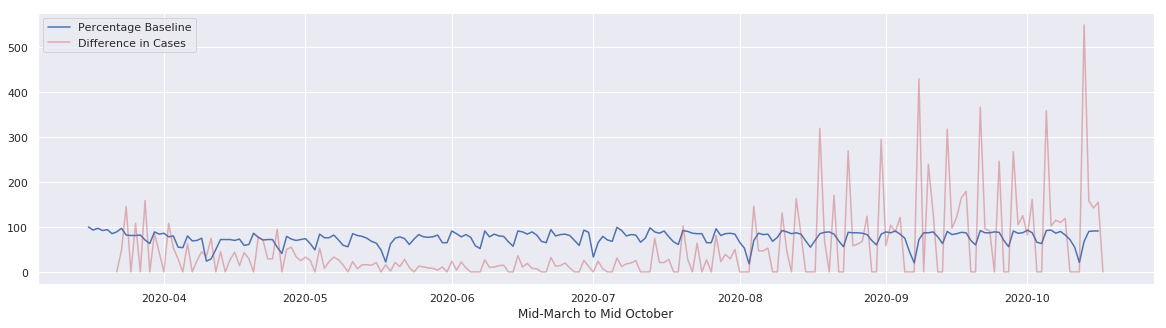

In [2]:
plt.figure(figsize = (20,5))
plt.plot(yvr["Date"], yvr['PercentOfBaseline'], 'b-', label = 'Percentage Baseline')
plt.plot(yvrCases["Date"], yvrCases['Difference'], 'r-', label = 'Difference in Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()

In [11]:
temp = yvr.shift(-1)
temp["PercentOfBaseline"] = temp["PercentOfBaseline"]

X = np.array(yvr['PercentOfBaseline'].head(100)).reshape(-1, 1)
y = np.array(temp["PercentOfBaseline"].head(100)).astype(int).reshape(-1, 1)


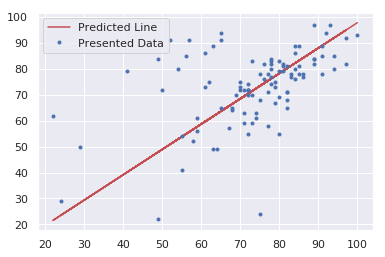

In [37]:
model = LinearRegression(fit_intercept = False)
model.fit(X, y)
plt.plot(X, model.predict(X), 'r-', label = "Predicted Line")
plt.plot(X, y, 'b.', label = 'Presented Data')
plt.legend()